<a href="https://colab.research.google.com/github/NguyenVanHien8502/image-classification/blob/main/MNIST_PJ3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount google drive

In [39]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import libraries

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import random
import struct
import gzip

import tensorflow as tf
from tensorflow import keras
from keras.api._v2.keras import layers


#1. Load Data from file .gz

In [41]:
#Load image train
filename = '/content/drive/MyDrive/Colab_Notebooks/train-images-idx3-ubyte.gz'

with gzip.open(filename, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    X_train = np.frombuffer(f.read(), dtype=np.uint8)
    X_train = X_train.reshape(size, nrows, ncols)

In [42]:
#Load label train
filename = '/content/drive/MyDrive/Colab_Notebooks/train-labels-idx1-ubyte.gz'

with gzip.open(filename, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_train = np.frombuffer(f.read(), dtype=np.uint8)
    y_train = y_train.reshape((size,))

In [43]:
#Load image test
filename = '/content/drive/MyDrive/Colab_Notebooks/t10k-images-idx3-ubyte.gz'

with gzip.open(filename, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    X_test = np.frombuffer(f.read(), dtype=np.uint8)
    X_test = X_test.reshape(size, nrows, ncols)

In [44]:
#Load label test
filename = '/content/drive/MyDrive/Colab_Notebooks/t10k-labels-idx1-ubyte.gz'

with gzip.open(filename, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_test = np.frombuffer(f.read(), dtype=np.uint8)
    y_test = y_test.reshape((size,))

#2. Check data

In [45]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [46]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [47]:
X_train.dtype, y_train.dtype

(dtype('uint8'), dtype('uint8'))

In [48]:
class_names = ["Number 0", "Number 1", "Number 2", "Number 3", "Number 4", "Number 5", "Number 6", "Number 7", "Number 8", "Number 9"]
class_nums = len(class_names)

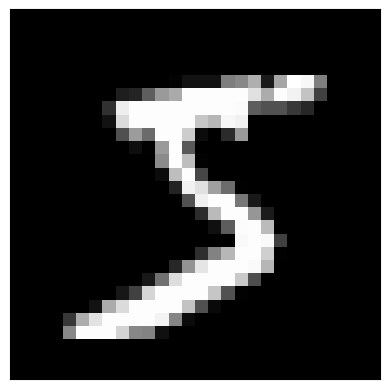

Label: Number 5


In [49]:
plt.imshow(X_train[0,:,:], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()
print(f"Label: {class_names[y_train[0]]}")

In [70]:
from typing import Optional
def plot_data(x_data: np.ndarray, y_data:np.ndarray, y_proba: Optional[np.ndarray] = None)->None:
  nrows, ncols=2, 4
  fig, axes = plt.subplots(nrows, ncols, figsize=(10,6))

  len_x = x_data.shape[0]
  for idx in range(nrows*ncols):
    ax = axes[idx // ncols, idx % ncols]
    img_idx = random.randint(0, len_x)
    ax.imshow(x_data[img_idx], cmap='gray')
    ax.set(xticks=[], yticks=[])
    color = 'green'

    true_label_str = f"True: {class_names[y_data[img_idx]]}"

    if y_proba is not None:
      predicted_idx = np.argmax(y_proba[img_idx])
      predicted_label = class_names[predicted_idx]
      color = 'red' if predicted_idx != y_data[img_idx] else color
      predicted_label_str = f"\nPredicted: {predicted_label}"

    img_title = true_label_str if y_proba is None else true_label_str + predicted_label_str
    ax.set_xlabel(img_title, color=color, fontsize=12)

  plt.tight_layout()
  plt.show()

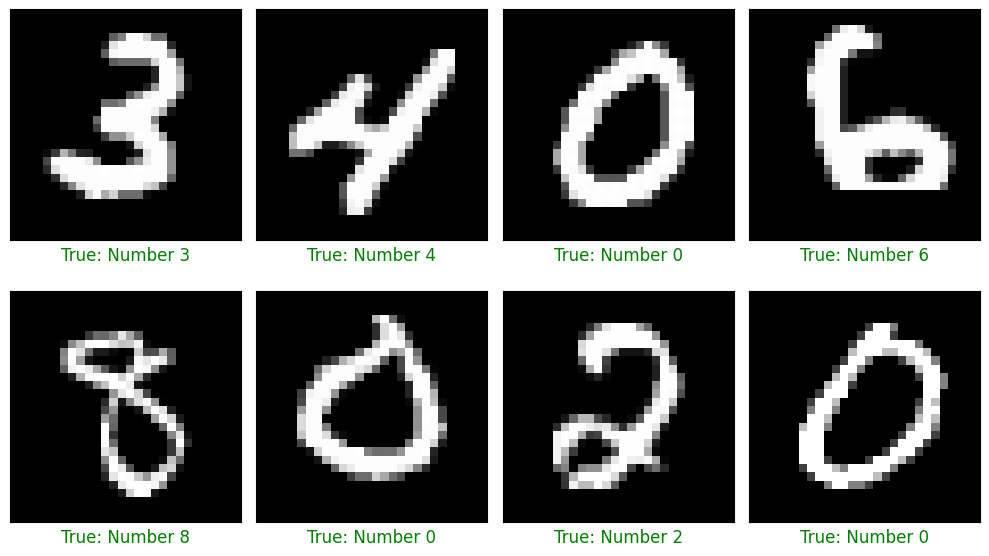

In [71]:
plot_data(X_train, y_train)

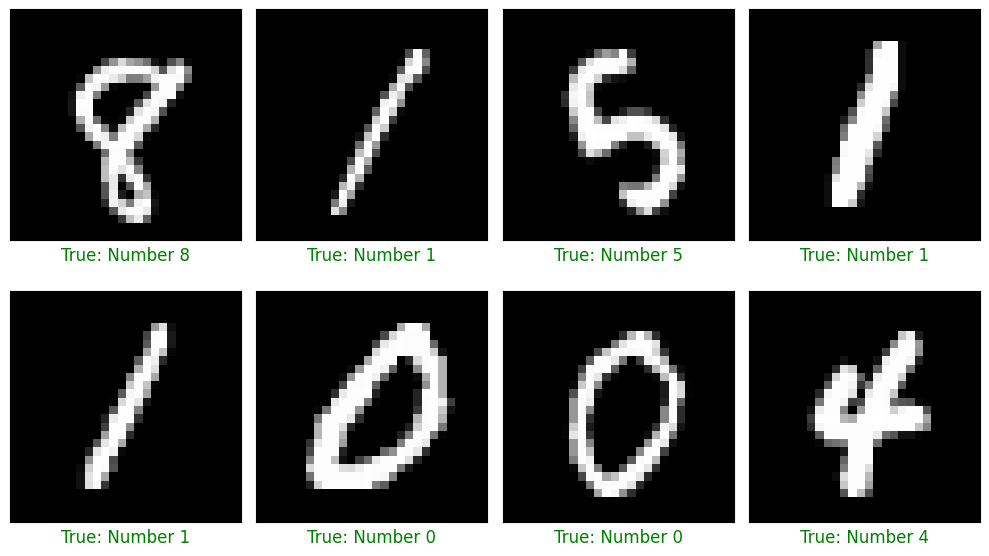

In [72]:
plot_data(X_test, y_test)

#3. Image Pre-processing

In [53]:
#Convert to float32 & scale images to the [0,1] range for training
X_train=X_train.astype(np.float32) / 255
X_test=X_test.astype(np.float32) / 255

In [54]:
X_train.shape, X_train.dtype

((60000, 28, 28), dtype('float32'))

In [55]:
X_test.shape, X_test.dtype

((10000, 28, 28), dtype('float32'))

In [56]:
#Make sure images have shape (60000, 28, 28) => (60000, 28, 28, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [57]:
X_train.shape, X_train.dtype

((60000, 28, 28, 1), dtype('float32'))

In [58]:
X_test.shape, X_test.dtype

((10000, 28, 28, 1), dtype('float32'))

In [59]:
#convert class vector to binary class matrics: 1 => [0 1 0 0 ...]
#1 => sparse_categorical_crossentropy
#[0 1 0 0 ...] => categorical_crossentropy
y_train_label = keras.utils.to_categorical(y_train, class_nums)
y_test_label = keras.utils.to_categorical(y_test, class_nums)

In [60]:
y_train[0], y_train_label[0]

(5, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32))

#4. Network (CNN) Architecture

In [61]:
input_shape = (28, 28, 1)

In [62]:
# model = keras.models.Sequential([
#     layers.Flatten(input_shape = input_shape), #(28, 28, 1)->vector 1 chiều (28*28)
#     layers.Dense(512, activation='relu'), #tìm hiểu về hàm relu: trả về chính giá trị đầu vào nếu nó lớn hơn 0, trả về 0 nếu nó nhỏ hơn hoặc bằng 0 => hàm này đóng vai trò bộ lọc, bỏ đi các giá trị nhỏ hơn hoặc bằng 0
#     layers.Dense(256, activation='relu'),
#     layers.Dense(class_nums, activation='softmax'), #tìm hiểu về hàm softmax: chọn ra giá trị lớn nhất trong tập bộ số: trả về giá trị bằng 1 cho số lớn nhất, bằng 0 cho các số còn lại => tìm y_predict dễ dàng, đỡ phải so sánh
#     ])

#Using CNN to predict
model = keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(class_nums, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

In [63]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [64]:
epochs = 10
batch_size = 128
history = model.fit(X_train, y_train_label,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=0.1
          )

Epoch 1/10
422/422 [==============================] - 52s 122ms/step - loss: 0.2250 - accuracy: 0.9291 - val_loss: 0.0492 - val_accuracy: 0.9860
Epoch 2/10
422/422 [==============================] - 54s 127ms/step - loss: 0.0509 - accuracy: 0.9842 - val_loss: 0.0485 - val_accuracy: 0.9873
Epoch 3/10
422/422 [==============================] - 51s 121ms/step - loss: 0.0338 - accuracy: 0.9896 - val_loss: 0.0332 - val_accuracy: 0.9908
Epoch 4/10
422/422 [==============================] - 50s 119ms/step - loss: 0.0237 - accuracy: 0.9928 - val_loss: 0.0328 - val_accuracy: 0.9898
Epoch 5/10
422/422 [==============================] - 49s 117ms/step - loss: 0.0181 - accuracy: 0.9941 - val_loss: 0.0343 - val_accuracy: 0.9908
Epoch 6/10
422/422 [==============================] - 52s 123ms/step - loss: 0.0145 - accuracy: 0.9952 - val_loss: 0.0338 - val_accuracy: 0.9918
Epoch 7/10
422/422 [==============================] - 49s 117ms/step - loss: 0.0106 - accuracy: 0.9963 - val_loss: 0.0339 - val_ac

In [ ]:
history_dict = history.history

In [ ]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
train_loss, val_loss = history_dict['loss'], history_dict['val_loss']
train_acc, val_acc = history_dict['accuracy'], history_dict['val_accuracy']

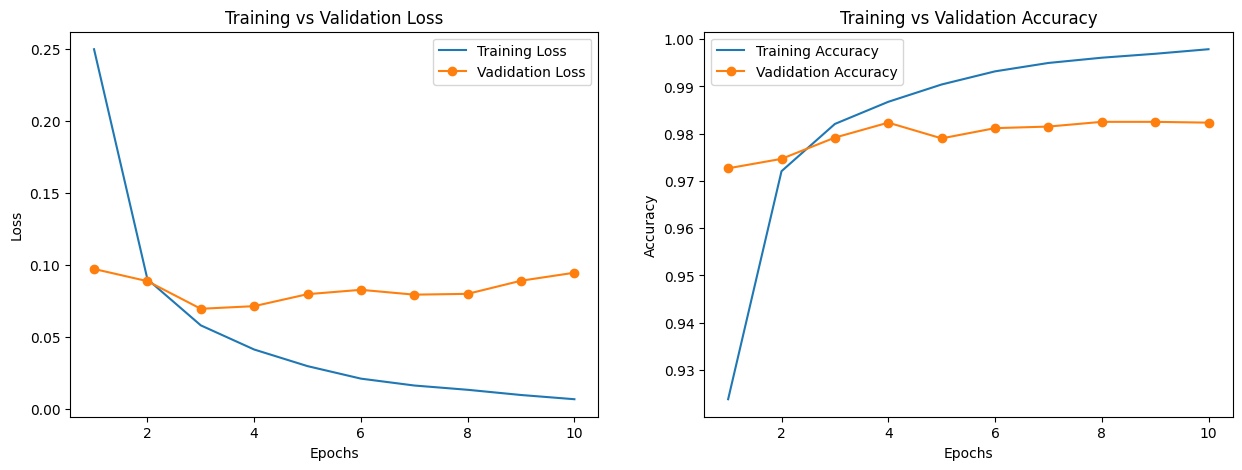

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
epochs_runs = [i+1 for i in range(epochs)]

ax1.plot(epochs_runs, train_loss, label='Training Loss')
ax1.plot(epochs_runs, val_loss, label='Vadidation Loss', marker='o')
ax1.set(title='Training vs Validation Loss', xlabel='Epochs', ylabel='Loss')
ax1.legend()

ax2.plot(epochs_runs, train_acc, label='Training Accuracy')
ax2.plot(epochs_runs, val_acc, label='Vadidation Accuracy', marker='o')
ax2.set(title='Training vs Validation Accuracy', xlabel='Epochs', ylabel='Accuracy')
ax2.legend()

plt.show()

#5. Model Evaluation

In [ ]:
score = model.evaluate(X_test, y_test_label)

313/313 [==============================] - 1s 3ms/step - loss: 0.0901 - accuracy: 0.9817


In [ ]:
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1]:.4f}")

Test Loss: 0.0901
Test Accuracy: 0.9817


In [ ]:
X_sample = X_test[:3] #Lấy 3 samples đầu tiên để check
y_proba_sample = model.predict(X_sample)

1/1 [==============================] - 0s 104ms/step


In [ ]:
y_proba_sample.round(3)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predictions = np.argmax(y_proba_sample, axis=1)
# [[0.1, 0.3, 0.5, 0.1],  # Mẫu 1 (Dòng 0)
#  [0.2, 0.2, 0.2, 0.4],  # Mẫu 2 (Dòng 1)
#  [0.7, 0.1, 0.1, 0.1]]  # Mẫu 3 (Dòng 2)

# axis=0 sẽ nghĩa là bạn muốn tìm giá trị lớn nhất trong từng cột (theo các mẫu dữ liệu).
# axis=1 sẽ nghĩa là bạn muốn tìm giá trị lớn nhất trong từng hàng (theo các lớp).

In [ ]:
[class_names[pred] for pred in predictions]

['Number 7', 'Number 2', 'Number 1']

In [ ]:
y_proba = model.predict(X_test)

313/313 [==============================] - 1s 3ms/step


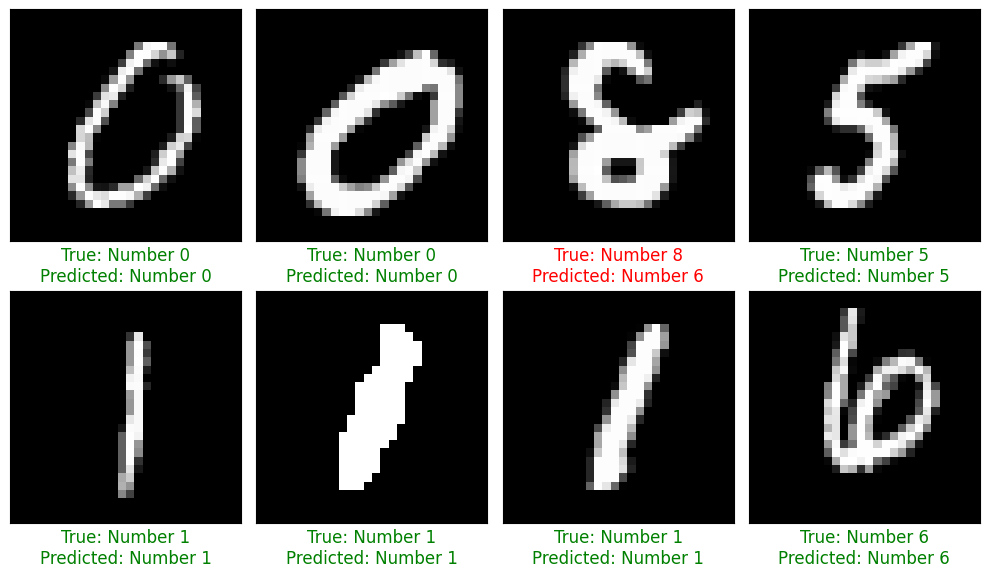

In [77]:
plot_data(X_test, y_test, y_proba)